In [1]:
import torch
import torchvision

model = torchvision.models.segmentation.__dict__["deeplabv3_resnet50"](aux_loss=True, num_classes=2)

checkpoint = torch.load("weights/model_29.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"], strict=False)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    model.to('cuda')

model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [2]:
# Download image examples
def download_from_url(url, image_name):
    import urllib

    try: 
        urllib.URLopener().retrieve(url, filename)
    except: 
        urllib.request.urlretrieve(url, filename)

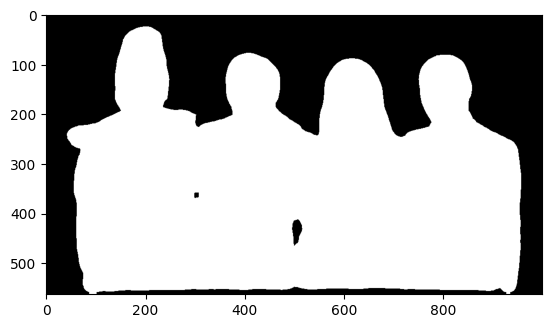

Image saved


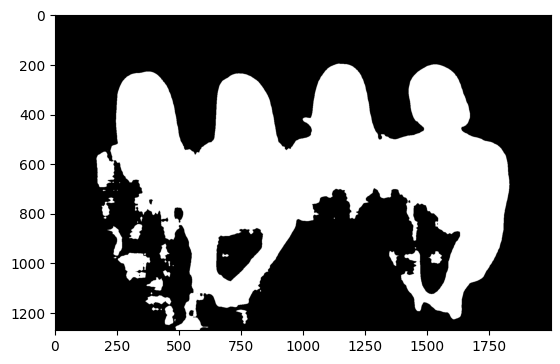

Image saved


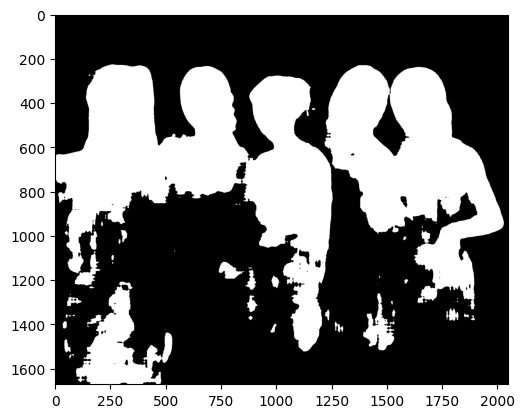

Image saved


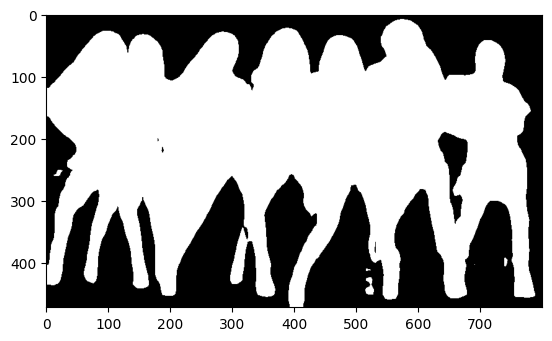

Image saved


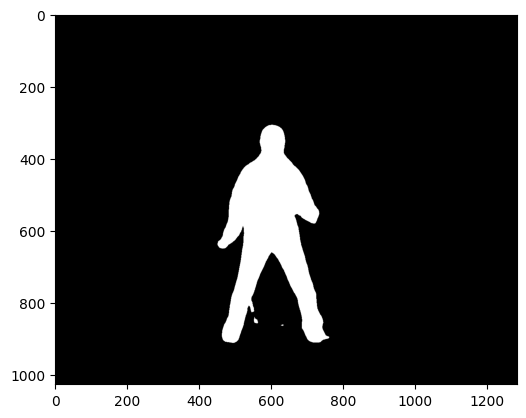

Image saved


In [3]:
import os
import cv2

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

def get_pred(filename, save=True):

    input_image = Image.open(filename)
    input_image = input_image.convert("RGB")

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


    # move the input to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0)
    return input_image, output_predictions

def get_mask(predictions, input_image):
    colors = [
        [0, 0, 0],
        [255, 255, 255]
    ]
    colors = np.array(colors, dtype=np.uint8)

    # plot the semantic segmentation predictions of 21 classes in each color
    mask = Image.fromarray(predictions.byte().cpu().numpy()).resize(input_image.size)
    mask.putpalette(colors)
    plt.imshow(mask)
    plt.show()

    return mask

def overlay(input_image, mask_image, filename):
    input_image = np.array(input_image)
    mask_image = np.array(mask_image)

    heatmap_img = cv2.applyColorMap(mask_image, cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(heatmap_img, 0.5, input_image, 0.5, 0)

    roi_img = cv2.bitwise_and(overlay_img, overlay_img, mask = mask_image)
    roi_img[mask_image[:] == 0,...] = input_image[mask_image[:] == 0,...]

    cv2.imwrite(f"results/{filename}", roi_img)
    print("Image saved")

filenames = os.listdir("./images")
for filename in filenames:
    path = os.path.join("./images/", filename)
    in_img, preds = get_pred(path)
    mask = get_mask(preds, in_img)
    overlay(in_img, mask, filename)
